## Paquetes necesarios

In [3]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns

TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 



## Imagen de ejemplo y calibración

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  3.88 €


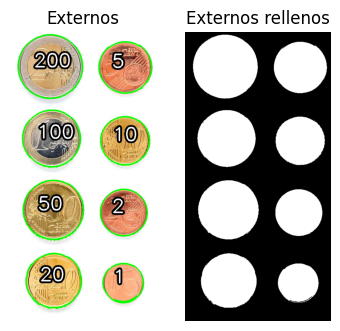

In [8]:
#Carga imagen ejemplo con monedas
img = cv2.imread('./Test/Monedas.jpg') 

#Convierte la imagen a todos de gris
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

umbral = 200
# Umbralizado binario invertido, dado que por defecto se asume objetos en blanco
_,img_th1 = cv2.threshold(img_gris,umbral,255,cv2.THRESH_BINARY_INV)

#Localiza contornos en imagen obtenida con umbral fijo
#Obtiene únicamente los contornos externos
contornos, _ = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

radiusArray = []

#Dibuja contornos externos rellenos en imagen vacía
#Imagen negra
img_cont = np.zeros(img_rgb.shape)
#Recorre los contornos externos
for c in contornos:
    #Área del contorno
    area = cv2.contourArea(c)
    #Área mínima
    if area > 10:
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        #Si el contorno tiene más de 5 puntos, añade el radio a la lista
        if c.shape[0] > 5:
            radiusArray.append(radio)

        #Dibuja los contornos
        cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)

#Ordena los radios de los círculos, de mayor a menor
radiusArray.sort(reverse=True)
#Tipos de monedas en centimos ordenadas de mayor a menor tamaño
#Se crea un diccionario con los valores de las monedas y su radio
coinData = dict(zip(radiusArray, [200,50,100,20,5,10,2,1]))

#Se procesa la imagen original
total = 0
for c in contornos:
    #Mínimo círculo que contiene al contorno
    (cx,cy),radio = cv2.minEnclosingCircle(c)
    for v in coinData:
        #Compara el radio de las monedas, con un 1% de tolerancia
        if (v == radio):
            total += coinData[v]
            # Dibuja texto con valor de la moneda, con borde para mejor visualización
            cv2.putText(img_rgb, str(coinData[v]),
                (int(cx-radio/2), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 15)
            cv2.putText(img_rgb, str(coinData[v]),
                (int(cx-radio/2), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
            
            break

#Muestra resultados
print("Total: ", total/100, "€")

plt.subplot(131)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

plt.subplot(132)
plt.axis("off")
plt.imshow(img_cont) 
plt.title('Externos rellenos')
#Guarda la imagen resultante a disco y muestra
plt.savefig('./Resultados/Monedas.jpg', bbox_inches='tight')
plt.show()

En esta celda, se define la función que se usa para tratar las imágenes, con diversas opciones de parámetros de entrada como el uso del umbral invertido o no, o el uso del método de Otsu para selección automática de umbral

In [11]:
def processImage(imgName, useInv=True, useAuto=True, umbral=200):
    """
    Procesa una imagen con monedas, detectando su valor total.

    Muestra la imagen con los contornos detectados y el valor de cada moneda y guarda la imagen resultante en disco.
    
    Parameters
    ----------
    imgName : str
        Nombre del archivo de imagen a procesar.
    useInv : bool, opcional
        Si es True, utiliza umbralizado binario invertido. Por defecto es True.
    useAuto : bool, opcional
        Si es True, utiliza el método de Otsu para selección automática del umbral.
        Por defecto es True.
    umbral : int, opcional
        Valor del umbral fijo si useAuto es False. Por defecto es 200.
    """
    
    #Carga imagen de monedas
    img = cv2.imread('./Test/' + imgName)

    #Tipo de umbralizado
    treshType = cv2.THRESH_BINARY_INV if useInv else cv2.THRESH_BINARY
    
    #Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Convierte la imagen a todos de gris
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Dos variantes de umbralizado
    if not useAuto:
        # Umbralizado binario
        _,img_th1 = cv2.threshold(img_gris,umbral,255,treshType)
    else:
        # Umbralizado con método de Otsu para selección automática del umbral
        _,img_th1 = cv2.threshold(img_gris,0,255,treshType+cv2.THRESH_OTSU)

    #Obtiene únicamente los contornos externos
    contornos, _ = cv2.findContours(img_th1, 
        cv2.RETR_EXTERNAL , 
        cv2.CHAIN_APPROX_SIMPLE)

    #Dibuja sobre la imagen de entrada sólo contornos externos
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

    #Dibuja contornos externos rellenos en imagen vacía
    #Imagen negra
    img_cont = np.zeros(img_rgb.shape)

    newRadiusArray = []

    # Calibración, requiere que la imagen tenga una moneda de 2€
    for c in contornos:
        #Área del contorno
        area = cv2.contourArea(c)
        #Área mínima
        if area > 10:
            cv2.drawContours(img_cont, [c], -1, (255,255,255), -1)
            #Mínimo círculo que contiene al contorno
            (cx,cy),radio = cv2.minEnclosingCircle(c)
            newRadiusArray.append(radio)

    newRadiusArray.sort(reverse=True)

    # Calcula la relación entre los radios de las monedas en la imagen de referencia y la nueva imagen
    ratio = newRadiusArray[0] / radiusArray[0]

    total = 0
    for c in contornos:
        #Mínimo círculo que contiene al contorno
        (cx,cy),radio = cv2.minEnclosingCircle(c)
        for v in coinData:
            if (abs(v*ratio - radio) < v*ratio*0.02):
                total += coinData[v]
                # Dibuja texto con valor de la moneda, con borde para mejor visualización
                cv2.putText(img_rgb, str(coinData[v]),
                    (int(cx-radio/2), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 15)
                cv2.putText(img_rgb, str(coinData[v]),
                    (int(cx-radio/2), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
                break

    print("Total: ", total/100, "€")

    plt.subplot(131)
    plt.axis("off")
    plt.imshow(img_rgb) 
    plt.title('Externos\n'+imgName)

    plt.subplot(132)
    plt.axis("off")
    plt.imshow(img_cont) 
    plt.title('Externos rellenos')
    #Guarda la imagen resultante a disco y muestra
    plt.savefig('./Resultados/' + imgName, bbox_inches='tight')
    plt.show()

Finalmente, se realiza el procesado de la imágenes usando la función anterior

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  3.88 €


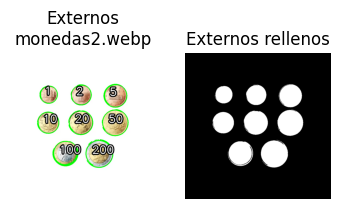

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  3.88 €


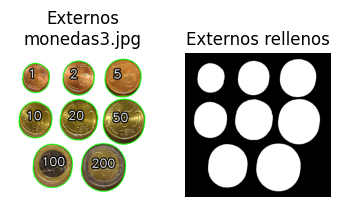

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  7.76 €


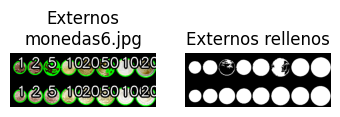

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  2.0 €


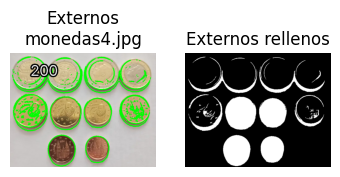

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  2.05 €


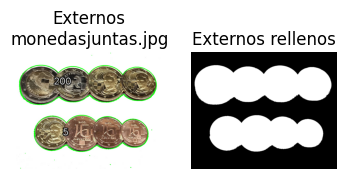

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


Total:  2.01 €


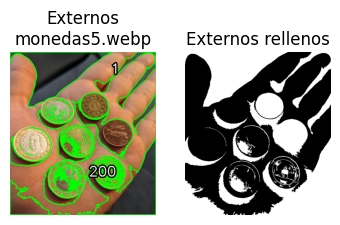

In [12]:
processImage('monedas2.webp', useInv=True, useAuto=False, umbral=210)
processImage('monedas3.jpg', useInv=True)
processImage('monedas6.jpg', useInv=False)
processImage('monedas4.jpg', useInv=True)
processImage('monedasjuntas.jpg', useInv=True)
processImage('monedas5.webp', useInv=True)

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

## Funciones para el procesamiento de las imágenes

In [17]:
def preprocesar_imagen(imagen):
    imagen_gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY) # Convertir a escala de grises
    imagen_norm = cv2.normalize(imagen_gris, None, 0, 255, cv2.NORM_MINMAX) # Normalizar entre 0 y 255
    imagen_suave = cv2.GaussianBlur(imagen_norm, (15, 15), 0) # Suavizar
    return imagen_suave

def recortar_imagen(imagen, recorte):
    return imagen[recorte]

def segmentar_imagen(imagen):
    umbral = cv2.adaptiveThreshold(
        imagen,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,   # Invertido: fondo negro, objetos blancos
        15,                      # Vecindad más pequeña, más sensible a detalle
        3                        # Eliminar partículas
    )
    return umbral

def extraer_caracteristicas_basicas(img, img_segmentada):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask_uint8 = (img_segmentada > 0).astype(np.uint8) * 255 # Máscara binaria
    color_promedio = cv2.mean(img_rgb, mask=mask_uint8)[:3]  # Color promedio rgb

    # Análisis forma (Area y circularidad)
    contornos, _ = cv2.findContours(img_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas, circularidades = [], []
    for c in contornos:
        area = cv2.contourArea(c)
        if area < 50:
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = 4 * np.pi * area / (perimetro ** 2) if perimetro > 0 else 0
        areas.append(area)
        circularidades.append(circularidad)

    area_media = np.mean(areas) if areas else 0
    circ_media = np.mean(circularidades) if circularidades else 0

    return {
        "area_media": round(area_media, 2),
        "circularidad_media": round(circ_media, 3),
        "color_R": round(color_promedio[0], 1),
        "color_G": round(color_promedio[1], 1),
        "color_B": round(color_promedio[2], 1)
    }

## Cargamos las muestras de entrenamiento

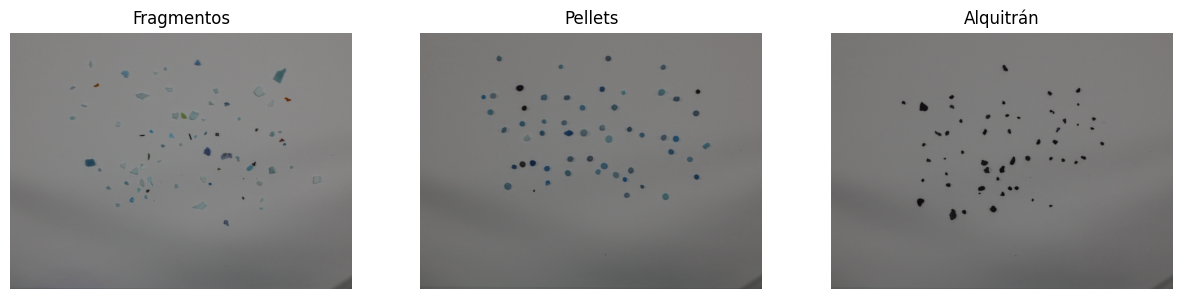

In [15]:
#Se cargan las imágenes
frag = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellet = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
alqui = cv2.imread('tar-03-olympus-10-01-2020.JPG')

#Mostramos
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.axis("off")
plt.imshow(frag)
plt.title('Fragmentos')

plt.subplot(132)
plt.axis("off")
plt.imshow(pellet)
plt.title('Pellets')

plt.subplot(133)
plt.axis("off")
plt.imshow(alqui)
plt.title('Alquitrán')
plt.savefig('./Resultados/carga_imagenes.jpg', bbox_inches="tight", dpi=300)

## Transformación de las imágenes a escala de grises

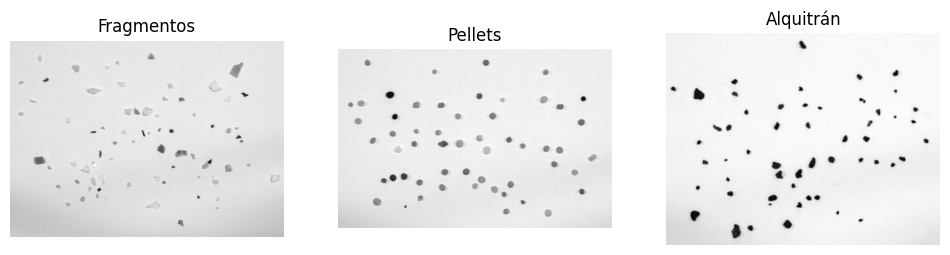

<Figure size 640x480 with 0 Axes>

In [18]:
# Secciones sobre las que trabajar
recorte_frag = (slice(200, 2750), slice(700, 4250))
recorte_pellets = (slice(175, 2400), slice(700, 4100))
recorte_tar = (slice(350, 2600), slice(900, 3800))

# Recortar imágenes
frag = recortar_imagen(frag, recorte_frag)
pellet = recortar_imagen(pellet, recorte_pellets)
alqui = recortar_imagen(alqui, recorte_tar)

# Normalizar las imágenes
frag_gris = preprocesar_imagen(frag)
pellet_gris = preprocesar_imagen(pellet)
alqui_gris = preprocesar_imagen(alqui)

#Mostrar las imágenes preprocesadas
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Fragmentos')
plt.axis("off")
plt.imshow(frag_gris, cmap='gray')

plt.subplot(132)
plt.title('Pellets')
plt.axis("off")
plt.imshow(pellet_gris, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_gris, cmap='gray')
plt.show()
plt.savefig('./Resultados/imagenes_gris.jpg', bbox_inches="tight", dpi=300)

## Segmentación de imágenes

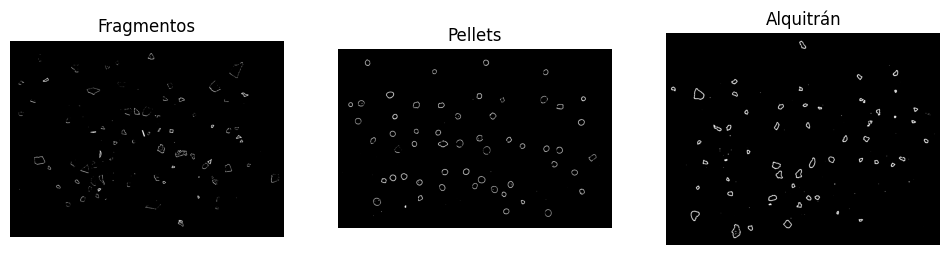

<Figure size 640x480 with 0 Axes>

In [19]:
frag_segmentada = segmentar_imagen(frag_gris)
pellet_segmentada = segmentar_imagen(pellet_gris)
alqui_segmentada = segmentar_imagen(alqui_gris)

#Mostrar imágenes segmentadas
plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title('Fragmentos')
plt.axis("off")
plt.imshow(frag_segmentada, cmap='gray')

plt.subplot(132)
plt.title('Pellets')
plt.axis("off")
plt.imshow(pellet_segmentada, cmap='gray')

plt.subplot(133)
plt.title('Alquitrán')
plt.axis("off")
plt.imshow(alqui_segmentada, cmap='gray')
plt.show()
plt.savefig('./Resultados/imagenes_segmentadas.jpg', bbox_inches="tight", dpi=300)

In [20]:
frag_features = extraer_caracteristicas_basicas(frag, frag_segmentada)
pellet_features = extraer_caracteristicas_basicas(pellet, pellet_segmentada)
alqui_features = extraer_caracteristicas_basicas(alqui, alqui_segmentada)

print("Fragmentos:", frag_features)
print("Pellets:", pellet_features)
print("Alquitrán:", alqui_features)

Fragmentos: {'area_media': np.float64(395.79), 'circularidad_media': np.float64(0.252), 'color_R': 87.5, 'color_G': 85.1, 'color_B': 77.7}
Pellets: {'area_media': np.float64(1845.03), 'circularidad_media': np.float64(0.402), 'color_R': 77.5, 'color_G': 68.6, 'color_B': 55.6}
Alquitrán: {'area_media': np.float64(2021.87), 'circularidad_media': np.float64(0.687), 'color_R': 30.0, 'color_G': 29.1, 'color_B': 30.6}


## Procesamiento de imagen test

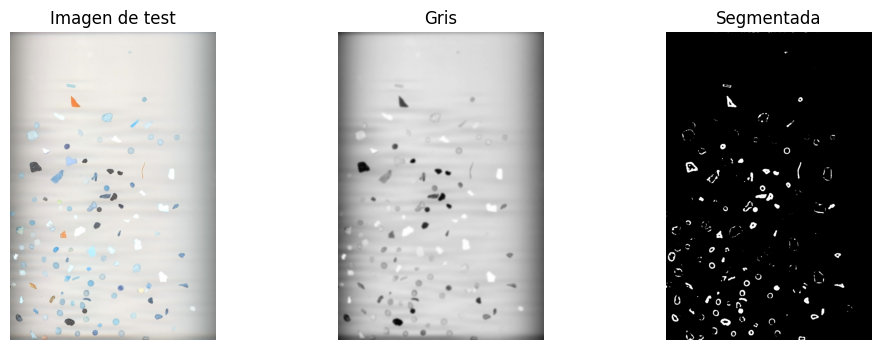

<Figure size 640x480 with 0 Axes>

In [21]:
#Mostrar imágenes
plt.figure(figsize=(12, 4))
imagen_test = cv2.imread('MPs_test.jpg')
plt.subplot(131)
plt.axis("off")
plt.imshow(imagen_test) 
plt.title('Imagen de test')

test_gris = preprocesar_imagen(imagen_test)
plt.subplot(132)
plt.title('Gris')
plt.axis("off")
plt.imshow(test_gris, cmap='gray')

test_segmentada = segmentar_imagen(test_gris)
plt.subplot(133)
plt.title('Segmentada')
plt.axis("off")
plt.imshow(test_segmentada, cmap='gray')
plt.show()
plt.savefig('./Resultados/tratamiento_imagen_test.jpg', bbox_inches="tight", dpi=300)

## Cantidad de microplásticos por clase

In [22]:
def clasificar(imagen_segmentada, imagen_color):
    contornos, _ = cv2.findContours(imagen_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clasificaciones = {'fragmentos': 0, 'pellets': 0, 'alquitran': 0}

    for c in contornos:
        area = cv2.contourArea(c)
        if area < 5:  # descartar ruido
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0

        # Color promedio dentro del objeto
        mask = np.zeros(imagen_segmentada.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        color_prom = cv2.mean(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB), mask=mask.astype(np.uint8))[:3]

        # Clasificación combinada
        if color_prom[0] < 122:  # oscuro → alquitrán
            clasificaciones['alquitran'] += 1
        elif circularidad > 0.5:  # redondez → pellet
            clasificaciones['pellets'] += 1
        else:  # lo demás → fragmentos
            clasificaciones['fragmentos'] += 1

    return clasificaciones

test_clasif = clasificar(test_segmentada, imagen_test)   # <- Aquí añades la imagen de test

print("Clasificación Test (imagen completa):", test_clasif)

Clasificación Test (imagen completa): {'fragmentos': 98, 'pellets': 53, 'alquitran': 13}


## Obtención de coordenadas de predicciones

In [24]:
def clasificar_coordenadas(imagen_segmentada, imagen_color, dist_min=10):
    contornos, _ = cv2.findContours(imagen_segmentada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    predicciones = []

    for c in contornos:
        area = cv2.contourArea(c)
        if area < 2:
            continue
        perimetro = cv2.arcLength(c, True)
        circularidad = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0
        x, y, w, h = cv2.boundingRect(c)

        # Color promedio dentro del objeto
        mask = np.zeros(imagen_segmentada.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        color_prom = cv2.mean(cv2.cvtColor(imagen_color, cv2.COLOR_BGR2RGB), mask=mask.astype(np.uint8))[:3]

        # Clasificación heurística
        if color_prom[0] < 120:  # oscuro → alquitrán
            clase = "TAR"
        elif circularidad > 0.5:  # redondo → pellet
            clase = "PEL"
        else:
            clase = "FRA"

        predicciones.append({
            "x_min": x, "y_min": y, "x_max": x + w, "y_max": y + h,
            "label": clase
        })

    # --- FUSIONAR CAJAS CERCANAS ---
    fusionadas = []
    for box in predicciones:
        x1, y1, x2, y2, label = box["x_min"], box["y_min"], box["x_max"], box["y_max"], box["label"]
        merged = False
        for f in fusionadas:
            # Comprobar si se solapan o están cerca y son de la misma clase
            if box["label"] == f["label"] and not (x2 < f["x_min"] - dist_min or x1 > f["x_max"] + dist_min or
                                      y2 < f["y_min"] - dist_min or y1 > f["y_max"] + dist_min):
                # Fusionar: ampliar los límites
                f["x_min"] = min(f["x_min"], x1)
                f["y_min"] = min(f["y_min"], y1)
                f["x_max"] = max(f["x_max"], x2)
                f["y_max"] = max(f["y_max"], y2)
                merged = True
                break
        if not merged:
            fusionadas.append(box)

    return fusionadas

predicciones = clasificar_coordenadas(test_segmentada, imagen_test)

## Comparativa de imagen con anotaciones vs predicciones

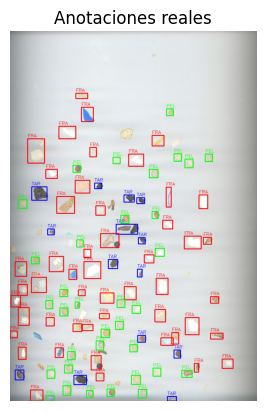

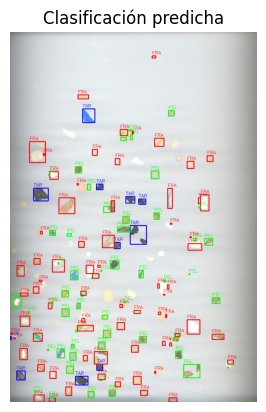

<Figure size 640x480 with 0 Axes>

In [25]:
colores = {
    "FRA": (0, 0, 255),   # Rojo 
    "PEL": (0, 255, 0),   # Verde
    "TAR": (255, 0, 0)    # Azul
}

# --- FUNCIÓN AUXILIAR PARA DIBUJAR CAJAS ---
def dibujar_cajas(img, cajas, titulo=""):
    for c in cajas:
        etiqueta = c["label"]
        x_min, y_min, x_max, y_max = int(c["x_min"]), int(c["y_min"]), int(c["x_max"]), int(c["y_max"])
        color = colores.get(etiqueta, (0, 0, 0))
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(img, etiqueta, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()
    plt.savefig('./Resultados/' + titulo + '.jpg', bbox_inches="tight", dpi=300)


# --- LEE ANOTACIONES REALES ---
csv_file = "MPs_test_bbs.csv"
anotaciones = []
with open(csv_file, newline="") as file:
    reader = csv.DictReader(file)
    for row in reader:
        anotaciones.append({
            "x_min": int(row["x_min"]),
            "y_min": int(row["y_min"]),
            "x_max": int(row["x_max"]),
            "y_max": int(row["y_max"]),
            "label": row["label"]
        })

# --- DIBUJAR RESULTADOS ---
dibujar_cajas(imagen_test.copy(), anotaciones, "Anotaciones reales")
dibujar_cajas(imagen_test.copy(), predicciones, "Clasificación predicha")

## Matriz de confusión y métricas


MÉTRICAS:
Tasa de acierto  = 0.604
Precisión = 0.631


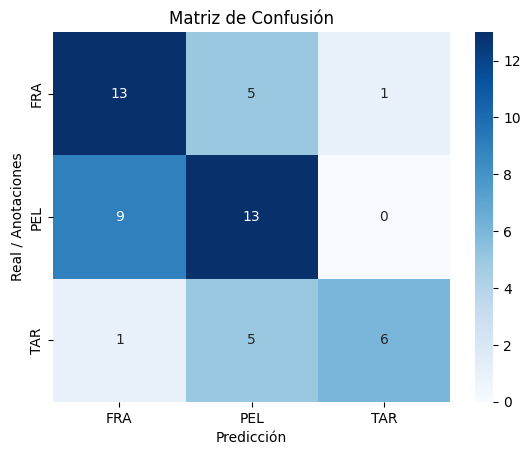

<Figure size 640x480 with 0 Axes>

In [27]:
# --- FUNCIÓN PARA CALCULAR INTERSECCIÓN ---
def iou(boxA, boxB):
    xA = max(boxA["x_min"], boxB["x_min"])
    yA = max(boxA["y_min"], boxB["y_min"])
    xB = min(boxA["x_max"], boxB["x_max"])
    yB = min(boxA["y_max"], boxB["y_max"])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA["x_max"] - boxA["x_min"]) * (boxA["y_max"] - boxA["y_min"])
    boxBArea = (boxB["x_max"] - boxB["x_min"]) * (boxB["y_max"] - boxB["y_min"])

    return interArea / float(boxAArea + boxBArea - interArea)

# --- EMPAREJAR POR INTERSECCIÓN ---
y_true, y_pred = [], []
iou_threshold = 0.5  # area de intersección

for gt in anotaciones:
    mejor_iou = 0
    mejor_pred = None

    for pred in predicciones:
        iou_val = iou(gt, pred)
        if iou_val > mejor_iou:
            mejor_iou = iou_val
            mejor_pred = pred

    # Solo cuenta si realmente se solapan
    if mejor_iou >= iou_threshold and mejor_pred is not None:
        y_true.append(gt["label"])
        y_pred.append(mejor_pred["label"])

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)

print("\nMÉTRICAS:")
print(f"Tasa de acierto  = {accuracy:.3f}")
print(f"Precisión = {precision:.3f}")

# --- MATRIZ DE CONFUSIÓN ---
labels = ["FRA", "PEL", "TAR"]
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicción")
plt.ylabel("Real / Anotaciones")
plt.title("Matriz de Confusión")
plt.show()
plt.savefig('./Resultados/matriz_confusion.jpg', bbox_inches="tight", dpi=300)
